In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Uvod

V predhodnih študijah se je izkazalo, da ima vsak uporabnik svoj slog branja novic, zato smo se tudi odločili za personalizacijo splošnega napovednega modela. Glede na to, da želimo personalizacijo doseči v čim krajšem času smo uporabili aktivno strojno učenje. Zaradi raznolikosti uporabnikov pa ne vemo, kateri algoritem aktivnega strojnega učenja bo na posamezniku deloval najboljše. V bolj dinamičnih okoljih so v članku [Adaptive Active Learning as a Multi-armed Bandit Problem](https://www.researchgate.net/publication/264902057_Adaptive_Active_Learning_as_a_Multi-armed_Bandit_Problem) predlagali uporabo večih metod aktivnega učenja, med katerimi menjavamo s pomočjo algoritma UCB. V našem primeru smo izbrali naslednje tehnike aktivnega strojnega učenja:

1. **Razmik prepričanosti (angl. Margin of Confidence)** - ta metoda vzame dva najbolj verjetna podatka na izhodu in preveri, ali je razlika med njunima verjetnostima izhoda dovolj velika. V primeru, da je potem vprašalnika uporabniku ne zastavimo. Na tem mestu velja omeniti, da na parametre prikaza novic gledamo kot na vhod. To pomeni, da iteriramo čez vse možne prikaze novic in pogledamo za katerega izmed njih je model v določenem trenutku najbolj prepričan, da se klasificira kot "Da". Težava na katero naletimo je, da se verjetnosti v tem primeru ne seštejejo v ena. Problem lahko rešimo, da verjetnosti normaliziramo s pomočjo funkcije softmax.
2. **Naključna odločitev** - druga metoda, ki smo jo uporabili za odločitev, ali je uporabniku potrebno zastaviti vprašalnik, je popolnoma naključna. To pomeni, da se v nekem trenutku naključno odločimo, ali prikažemo vprašalnik. Prednost metode, ki je čisto naključna je ta, da bo raziskovala najbolj raznolik prostor podatkov.
3. **Naključno z upoštevanjem porazdelitve fizične aktivnosti** - glede na to, da se je pri analizi podatkov kazal velik vpliv fizične aktivnosti na končno oceno uporabnika smo se odločili na podlagi njene porazdelitve naključno zastaviti vprašalnik. Iz prve študije smo ugotovili, da uporabniki največ berejo novice, ko so pri miru in nam primanjkujejo podatki, ko se vozijo ali pa se sprehajajo. Da bi dali prednost zbiranju podatkov, ko uporabniki hodijo in se vozijo moramo takrat zastaviti največji delež vprašalnikov. To lahko dosežemo z upoštevanjem trenutne porazdelitve fizčne aktivnosti. Verjetnost, da se bo vprašalnik pojavil, ko je uporabnik pri miru mora biti najmanjša. Višja morata biti verjetnost pojavitve vprašalnika med hojo, najvišja pa med vožnjo v avtomobilu, saj imamo takih podatkov najmanj.
4. **Vzorečnje najmanj verjetnih izhodov (angl. Least Confidence sampling)** - pri tej metodi iščemo podatke, ko je verjetnost najboljšega prikaza novic pod odločitveno mejo modela, ki znaša 0.5. To pomeni, da bomo vprašalnik zastavali takrat, ko je verjetnost najboljšega prikaza novic, ki ga model označi kot "Da" pod vrednostjo 0.5.

# Algoritem UCB

Na področju spodbujevalnega strojnega učenja mora agent na podlagi interakcije z okolico sklepati, katera akcija je najboljša. Naloga agenta je torej iskanje strategije oz. zaporedja akcij brez vnaprej označenih podatkov. Iskanje učinkovite strategije menjave metod aktivnega strojnega učenja si lahko predstavljamo kot [Multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit). V tem primeru je agent hazarder, ki želi maksimizirat svoj izkupiček z igranjem na avtomatih. Na vsakem koraku se mora ta namreč odločiti, ali igrati na avtomatu, ki je do sedaj prinesel največji dobiček ali pa na drugem, ki bi morda lahko prinesel še višjo nagrado. V našem primeru se avtomati za srečo preslikajo v tehnike aktivnega strojnega učenja. Potrebno je uravnotežiti število izbir metode aktivnega strojnega učenja, ki se je do sedaj izkazala kot najboljša in poskuse preostalih metod, ki bi se morda lahko izkazale kot še boljše.

Alogirtem UCB (Upper Confidence Bound) se je izkazal kot eden bolj učinkovitih pri reševanju omenjenega problema. Ta temelji na sledeči enačbi:

<img src="https://latex.codecogs.com/svg.latex?\Large&space;A_t=argmax_a(Q_t(a) + c \sqrt\frac{ln(t)}{N_t(a)})"/>


* Prvi del enačbe Qt(a) predstavlja povprečno nagrado, ki jo je agent do sedaj pridobil z uporabo tehnike a in omogoča izkoriščanje uporabe do sedaj najboljše tehnike. 

* Drugi del enačbe pa predstavlja zgornjo mejo, ki jo agent dopušča za raziskovanje nove tehnike aktivnega strojnega učenja in je odvisna od števila do sedaj znanih poskusov na tehniki a. Večkrat kot smo izbrali določeno tehniko, manj jo želimo ponovno poskusiti, zato se tudi v imenovalcu nahaja člen Nt(a), ki predstavlja število do sedaj znanih poskusov na izbrani tehniki. Pri tem pa moramo upoštevati trenutno učinkovitost tehnike a, ki se nahaja v prvem delu enačbe (Qt(a)).

Grafična predstavitev zgornje enačbe:

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200126022459/Screenshot-2020-01-26-at-2.24.37-AM.png"/>

# Analiza zbranih podatkov druge študije

V nadaljevanju bodo predstavljeni zbrani podatki druge študije, ki je trajala štiri tedne in v kateri je sodelovalo sedem ljudi. V prvem delu študije, ki je trajal dva tedna smo skušali splošni napovedni model personalizirati s pomočjo algoritma UCB. V drugem delu študije pa smo želeli z vsakodnevno menjavo personaliziranega in splošnega napovednega modela primerjati njuno učinkovitost.


In [2]:
## nalaganje podatkov

column_names_r = ["uID", "margin_of_conf", "random", "random_by_ua", "least_confidence", "total_reward", "all_pulls", "regret"]
rewards_df = pd.read_csv("Dataset/rewards.csv", header=None, names=column_names_r, sep=";")

column_names_p = ["uID", "margin_of_conf", "random", "random_by_ua", "least_confidence", "all_pulls"]
pulls_df = pd.read_csv("Dataset/pulls.csv", header=None, names=column_names_p, sep=";")

column_names_b = ["uID", "trial", "bandit_index", "bandit_decision", "reward", "regret", "total_reward"]
bandit_df = pd.read_csv("Dataset/bandit.csv", header=None, names=column_names_b, sep=";")

column_names_pr = ["uID", "user_activity", "env_b", "theme", "layout", "fontSize", "predictionProb", "feedback"]
pred_df = pd.read_csv("Dataset/predictions.csv", header=None, names=column_names_pr, sep=";")

column_names_ph2 = ["uID", "algo", "user_activity", "env_b", "theme", "layout", "fontSize", "feedback"]
ph2_df = pd.read_csv("Dataset/phase2.csv", header=None, names=column_names_ph2, sep=";")

# Analiza algoritma UCB in posameznih tehnik aktivnega strojnega učenja

V spodnji tabeli je predstavljena učinkovitost algoritma UCB in posameznih tehnik aktivnega strojnega učenja na posamezniku. 

V prvem stolpcu tabele se nahajajo identifikatorji uporabnikov. Drugi stolpec predstavlja vektor nagrad, ki jih je pridobila posamezna tehnika aktivnega strojnega učenja, ki si sledijo v naslednjem zaporedju:

1. Razmik prepričanosti (angl. Margin of Confidence) 
2. Naključna odločitev postavitve vprašalnika
3. Naključno z upoštevanjem porazdelitve fizične aktivnosti
4. Vzorečnje najmanj verjetnih izhodov (angl. Least Confidence sampling)


V tretjem stolopcu vidmo kolikokrat je bila tehnika aktivnega strojnega učenja izbrana. V četrtem se nahaja skupno število poskusov algoritma UCB. V petem razberemo skupno vsoto, ki so jo dobile tehnike aktivnega strojnega učenja. V predzadnjem stolopcu se nahaja število vseh poskusov algoritma UCB, ko je naletel na kazen. V zadnjem pa lahko razberemo delež napačnih izbir algorima UCB.


## Analiza tabele

* Pri uporabnikih z identifikatorji 0, 2 in 3 se kaže visoka učinkovitost prvih dveh metod aktivnega učenja. Prav tako je odstotek napačnih izbir tehnik aktivnega učenja majhen (12.67%, 16%, 8.33%). Na teh uporabnikih je algoritem UCB zaradi visokih vsot skupne nagrade največkrat tudi uporabil prvo metodo. Pri uporabniku z indeksom 3 pa se kaže nekoliko bolj enakomerna menjava prve in druge metode aktivnega učenja. 

* Čeprav je uporabnik z identifikatorjem 1 aplikacijo malo uporabljal (prispeval je le 14 vnosov), algoritem UCB vseeno ni naredil preveliko število napačnih izbir. Delež zgrešenih poskusov je namreč le 21.43%. Vseeno se tudi pri tem uporabniku izkažeta prvi dve metodi aktivnega učenja kot najboljši. 

* Uporabnik z identifikatorjem 4 je prispeval v prvem delu druge študije najmanj vnosov. Pri njem se tudi kaže največji delež napačnih izbir metod aktivnega strojnega učenja, ki znaša 40%. Vzrok za tako velik odstotek napačnih odločitev je ta, da algoritem UCB ni uspel konvergirati k najboljši metodi, saj uporabnik aplikacije ni veliko uporabljal. Vseeno sta se prvi dve metodi aktivnega učenja pri tem uporabniku izkazali nekoliko boljši kot drugi dve.

* Nobena izmed metod aktivnega učenja ne odstopa pri uporabikih z identifikatorji 5 in 6. Posledično tudi algoritem UCB ni uspel pri njima določiti, katera metoda aktivnega učenja je najboljša. Čeprav je uporabnik z identifikatorjem 5 prispeval velik delež vnosov algoritem UCB na tem uporabniku ni deloval dobro. Skupna nagrada je celo negativna prav tako pa je število posameznih poskusov enakomerno porazdeljeno. Omenjena dva uporabnika bomo v nadaljevanju analize podrobneje analizirali.

| Uporabnik | Skupna nagrada posameznih metod | Število posameznih poskusov | Skupno števlo poskusov | Skupna nagrada | Število zgrešenih poskusov | Delež zgrešenih poskusov |
|-----------|---------------------------------|-----------------------------|------------------------|----------------|----------------------------|--------------------------|
| 0         | [31.72, 5.47, -3.40, -1.98]     | [50, 16, 2, 3]              | 71                     | 31.82          | 9                          | 12.67%                   |
| 1         | [3.79, 4.08, -1.90, -1.93]      | [5, 6, 1, 2]                | 14                     | 4.04           | 3                          | 21.43%                   |
| 2         | [15.34, 2.07, -1.95, -1.75]     | [15, 6, 2, 2]               | 25                     | 13.71          | 4                          | 16.00%                   |
| 3         | [26.04, 12.60, -1.41, -1.85]    | [34, 21, 3, 2]              | 60                     | 35.38          | 5                          | 8.33%                    |
| 5         | [-0.02, 2.50, -0.50, -2.50]     | [17, 23, 15, 11]            | 66                     | -0.27          | 8                          | 12.12%                   |
| 6         | [1.38, 0.39, -1.71, -2.25]      | [6,5,3,2]                   | 16                     | -2.20          | 5                          | 31.25%                   |

# Graf kumulativne nagrade skozi čas

Radi bi preverili spreminjanje vsote nagrad skozi čas. Na ordinatni osi bo torej vsota prejete nagrade do n-tega poskusa. Zaradi preglednosti bomo narisali dva različna grafa, saj so udeleženci raziskave prispevali različno število vnosov. Posledično bi graf funkcije bil manj pregleden za tiste uporabnike, ki so aplikacijo manj uporabljali.

Iz spodnjih grafov, vidimo, da je vsota nagrad skozi čas naraščala pri večini uporabnikov.

Uporabnika z identifikatorji 5 (zelena črta na prvem grafu) in 6 (rdeča črta na drugem grafu) tako kot pri zgornji tabeli odstopata od ostalih uporabnikov.

In [3]:
def plot_rewards(userIDs, ax):
    for userID in userIDs:
        rewards = bandit_df.loc[( bandit_df["uID"] == userID )]["total_reward"].tolist()
        trials = bandit_df.loc[( bandit_df["uID"] == userID )]["trial"].tolist()
        ax.legend(userIDs)
        ax.plot(trials, rewards, label=userID)

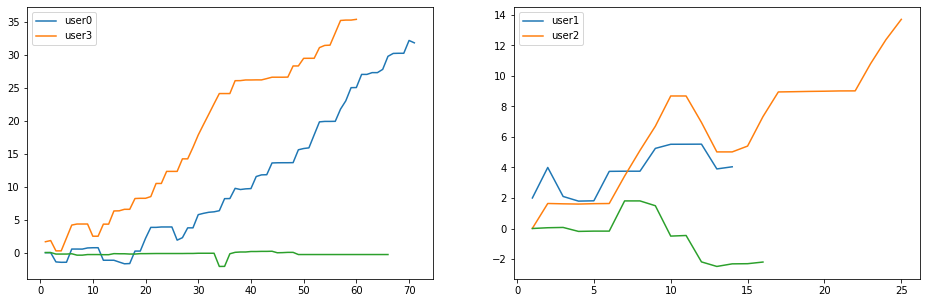

In [6]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
plot_rewards(["user0", "user3", "user5"], ax1)
ax2 = fig.add_subplot(1,2,2)
plot_rewards(["user1", "user2", "user6"], ax2)

# Analiza odgovorov na vprašalnik

Omenili smo, da bomo poiskali razlog, zakaj algoritem UCB pri zadnjih dveh uporabnikih ni deloval dovolj dobro. 

V nadaljevanju si bomo zato najprej pogledali, ali se morda odgovori pri šestem in sedmem uporabniku, na zastavljen vprašalnik, med seboj močno razlikujejo od ostalih uporabnikov.

In [7]:
def draw_pie(labels, sizes, ax, userID):
    ax.set_title(userID)
    ax.pie(sizes, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')


In [8]:
def analyze_user_y_n():
    fig = None
    for i in range(0,7):
        
        if i%3 == 0:
            fig = plt.figure(figsize=(15, 5))

        ax = fig.add_subplot(1,3,i%3 + 1)
        userYes = len(pred_df.loc[ (pred_df["uID"] == "user"+str(i)) & (pred_df["feedback"]  == 'Y')])
        userNo = len(pred_df.loc[ (pred_df["uID"] == "user"+str(i)) & (pred_df["feedback"]  == 'N')])
        print("User", i, "Yes = ",userYes, "No = ", userNo)
        draw_pie(["yes", "no"], [userYes, userNo], ax, "user"+str(i))

User 0 Yes =  46 No =  25
User 1 Yes =  7 No =  7
User 2 Yes =  8 No =  17
User 3 Yes =  34 No =  26
User 4 Yes =  7 No =  3
User 5 Yes =  64 No =  2
User 6 Yes =  13 No =  3


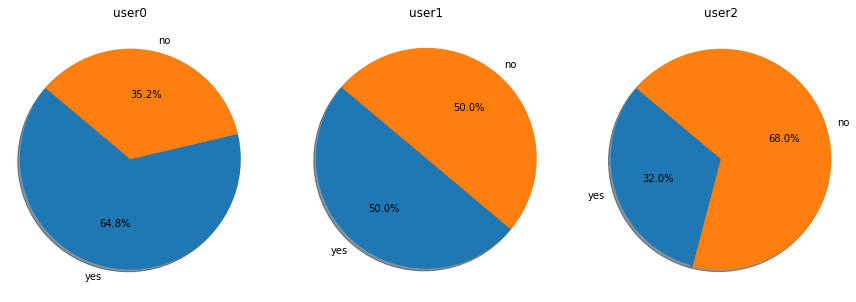

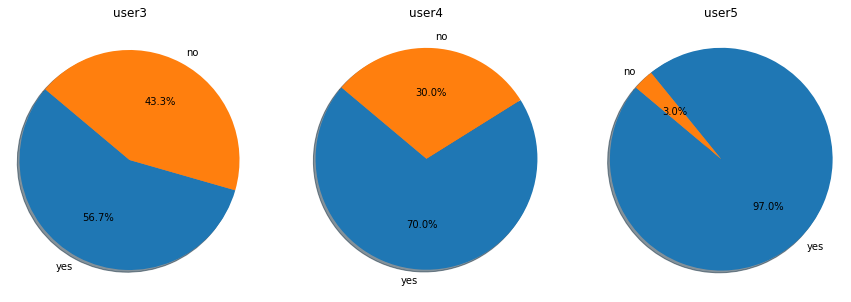

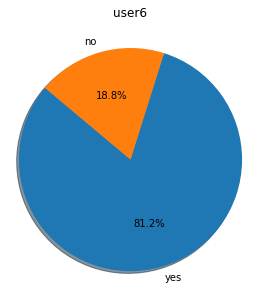

In [9]:
analyze_user_y_n()

Zgornji tortni diagrami so prikaz uporabnikovih odgovorov v prvem delu študije. Udeleženci raziskave so imeli na voljo le dva odgovora "Da" in "Ne". 

Pri petem in šestem tortnem diagramu, ki prikazuje odgovore najbolj kritičnih uporabnikov v prvem delu študije (algoritem UCB je imel nagrado negativno) opazimo razlike v odgovorih v primerjavi z ostalimi.

Deleža njunih odgovorov z "Da" znašata 81.2% in kar 97%. To pomeni, da je obema uporabnikoma, katerikoli prikaz novic v vsakem trenutki, bil všeč. Posledično je to lahko, razlog za slabšo učinkovitost algoritma UCB, saj sta oba uporabnika z vsemi uporabniškimi vmesniki zadovoljna. Peti uporabnik, je tudi prispeval veliko manj vnosov (16 vnosov) kot šesti (66 vnosov). Razlog za slabšo učinkovitost algoritma UCB pri petem uporabniku je lahko tudi premajhna količina novih podatkov.


# Primerjava učinkovitosti splošnega in personaliziranega napovednega modela

Omenili smo, da bomo v drugem delu druge študije primerjali učinkovitost splošnega in personaliziranega napovednega modela. Spodnja tabela število napovedi omenjenih modelov in delež napovedi s katerimi je bil uporabnik zadovoljen. 

Iz spodnje tabele opazimo, da personalizacija napovednih modelov, poveča uporabnikovo zadovoljstvo pri vseh uporabnikih razen pri uporabniku z identifikatorjem 4. Razlog za to je, da je ta v prvem delu študije prispeval najmanj podatkov (zbranih je bilo samo 10 vnosov). Prav tako pa je število napovedi splošnega modela pri tem uporabniku veliko manjša od števila napovedi personaliziranega. Razlog za to je, da je pojavitev vprašalnika odvisna od števila kolikrat uporabnik vstopi na zaslon za prikaz novic.

Prav tako je zadnji uporabnik prispeval v drugem delu študije malo vnosov (skupno 13), a se vseeno kaže višja učinkovitost delovanja personaliziranega napovednega modela.

| Uporabnik | Št. napovedi splošnega modela | Št. napovedi personaliziranega modela | Točnost splošnega modela | Točnost personaliziranega modela |
|-----------|-------------------------------|---------------------------------------|--------------------------|----------------------------------|
| 0         | 32                            | 45                                    | 47%                      | 71%                              |
| 1         | 9                             | 13                                    | 44%                      | 69%                              |
| 2         | 49                            | 31                                   | 52%                      | 63%                              |
| 3         | 15                            | 26                                    | 47%                      | 73%                              |
| 5         | 31                            | 48                                    | 68%                      | 98%                              |
| 6         | 6                             | 7                                     | 33%                      | 71%                              |

# Primerjava napovedi personaliziranega in splošnega napovednega modela na posamezniku

V nadaljevanju si bomo pogledali, kako se razlikujejo napovedi personaliziranega in splošnega napovednega modela. Večina udeležencev je aplikacijo uporabljala, ko je bila vrednost fizične aktivnosti enaka STILL (kar prikazuje spodnji tortni diagram). Posledično ne bomo podrobneje analizirali razlik napovednih modelov za preostale vrednosti fizične aktivnosti. 

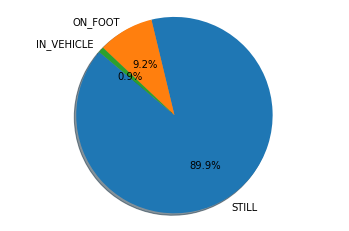

In [28]:
def draw_pie2(labels, sizes):
    plt.pie(sizes, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()
    
count_still = len(ph2_df.loc[(ph2_df["user_activity"] == "STILL")])
count_foot = len(ph2_df.loc[(ph2_df["user_activity"] == "ON_FOOT")])
count_vehicle = len(ph2_df.loc[(ph2_df["user_activity"] == "IN_VEHICLE")])
draw_pie2(["STILL", "ON_FOOT", "IN_VEHICLE"], [count_still, count_foot, count_vehicle])

Pri nadalnji analizi bomo svetlost okolice razdelili v dve skupini.

V prvi se bodo nahajale vrednosti na intervalu [0 lux,100 lux], v drugi bodo vrednosti, kjer je svetlost okolice večja od 100 lux. Mejo za delitev 100 lux smo izbrali, ker v [tabeli](https://en.wikipedia.org/wiki/Lux) lahko razberemo, da vrednosti večje od 100 lux predstavljajo odprte prostore, medtem ko vrednosti manjše od 100 lux zaprte. 

Ko je svetlost okolice večja od 100 lux, lahko pričakujemo, da uporabniki hodijo, se vozijo ali pa sedijo na odprtem. Kot smo omenili, kadar so vrednosti manjše od 100 lux lahko pričakujemo, da so uporabniki v zaprtem. Posledično lahko sklepamo, da posamezniki takrat večinoma sedijo oz. mirujejo. Svetlost okolice na ta način predstavlja približek napovedi fizične aktivnosti uporabnika, vseeno ne moremo z gotovostjo trditi, kaj uporabnik počne le na podlagi svetlosti okolice.

Kakovost napovedi fizične aktivnosti le na podlagi svetlosti okolice, lahko preverimo s pomočjo spodnjih tortnih diagramov. Izkaže se, da delež vnosov, ko je uporabnik pri miru in je svetlost okolice večja od 100 lux znaša le 24%. V primeru, ko se uporabnik sprehaja je svetlost okolice v 59.3% primerih večja od 100 lux. Med vožnjo se izkaže, da je 80% vnosov takih, da je svetlost okolice večja od 100 lux. Pri tem moramo omeniti, da je vseh vnosov, ko se uporabnik vozi le pet. 

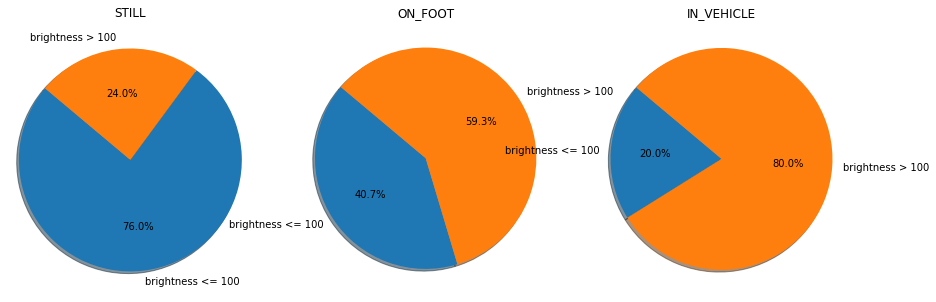

In [29]:
def count_occurances(df1, df2, activity):
    b1 = len(df1.loc[(df1["user_activity"] == activity) & (df1["env_b"] <= 100)]["env_b"])
    b2 = len(df1.loc[(df1["user_activity"] == activity) & (df1["env_b"] > 100)]["env_b"])
    b3 = len(df2.loc[(df2["user_activity"] == activity) & (df2["env_b"] <= 100)]["env_b"])
    b4 = len(df2.loc[(df2["user_activity"] == activity) & (df2["env_b"] > 100)]["env_b"])
    return (b1 + b3, b2 + b4)

    
def activity_brightness(df1, df2):
    v1 = count_occurances(df1, df2, "STILL")
    v2 = count_occurances(df1, df2, "ON_FOOT")
    v3 = count_occurances(df1, df2, "IN_VEHICLE")
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    draw_pie(["brightness <= 100", "brightness > 100"], [v1[0], v1[1]], ax1, "STILL")
    draw_pie(["brightness <= 100", "brightness > 100"], [v2[0], v2[1]], ax2, "ON_FOOT")
    draw_pie(["brightness <= 100", "brightness > 100"], [v3[0], v3[1]], ax3, "IN_VEHICLE")

activity_brightness(pred_df, ph2_df)

Pri vsakem uporabniku bo predstavljena najprej tabela učinkovitosti in porazdelitve posameznih napovedi za personaliziran napovedni model. Temu sledi tabela, ki je sestavljena v enakem formatu za splošni model. S pomočjo analize omenjenih tabel lahko razberemo, kako se se napovedi med modeloma razlikujejo. Navedeni tabeli bosta sestavljeni iz sledečih stolpcev:

1. Nivo svetlosti okolice - ta pove interval vrednosti svetlosti okolice v luxih za katerega nas zanima razlika med modeloma.
2. Točnost napovednih modelov - predstavlja delež pravilnih napovedi posameznih napovednih modelov.
3. Porazdelitev spremenljivke 'layout' - spremenljivka 'layout' lahko zavezma dve različni vrednosti, in sicer 'largeCards' in 'xLargeCards'. Porazdelitev spremenljivke 'layout' je predstavljena z vektorjem, ki vsebuje dve vrednosti. Prva predstavlja število napovedi 'largeCards' pogleda, druga pa število napovedi vrednosti 'xLargeCards'.
4. Porazdelitev spremenljivke 'theme' - spremenljivka 'theme' lahko zavzema dve različne vrednosti 'light-theme' ali 'dark theme'. Vektor je predstavljen v sledeči obliki: [št. napovedi light-theme, št. napovedi dark-theme].
5. Porazdelitev spremenljivke 'fontSize' - spremenljivka 'fontSize' ima lahko dve vrednosti 'small-font' ali 'large-font'. Porazdelitev spremenljivke 'fontSize' bo predstavljena z vektorjem v formatu [št. napovedi small-font, št. napovedi large-font].

Podrobnejše analize porazdelitve parametrov prikaza novic na zadnjem uporabniku nebomo izvedli, saj je ta v drugem delu druge študije prispeval le 13 podatkov. Vseeno lahko omenimo, da je točnost personaliziranega napovednega modela iz zgornje tabele za 38% višja od splošnega.

In [12]:
def transform_b(b):
    if b <= 100:
        return "L1"
    return "L2"

def analyzeParameter(dfP, dfG, par_name, par_values):
    results_p = []
    results_g = []
 
    
    
    for par_value in par_values:
        p = len(dfP.loc[ dfP[par_name] == par_value ])
        pp_y = len(dfP.loc[ (dfP[par_name] == par_value) & (dfP["feedback"] == "Y") ])
        pp_n = p - pp_y
                   
        g = len(dfG.loc[ dfG[par_name] == par_value ])
        gg_y = len(dfG.loc[ (dfG[par_name] == par_value) & (dfG["feedback"] == "Y") ])
        gg_n = g - gg_y

        results_p.append(p)
        results_g.append(g)       
    
    print("Splosna porazdelitev podatkov napovedi:")
    print(par_name, results_p, results_g)
    print("==")
    print()
        
    
ph2_df["env_b2"] = ph2_df["env_b"].map(lambda brightness: transform_b(brightness))

def model_comparison(userID, df):
    
    for eb2 in ["L1", "L2"]:
        
        print("BrightnessLevel", eb2)
       
        # full dataframe personalized model
        full_df_p_m = df.loc[(df["algo"] == 0) & (df["uID"] == userID) & (df["env_b2"] == eb2)]
        # full dataframe generalized model
        full_df_g_m = df.loc[(df["algo"] == 1) & (df["uID"] == userID) & (df["env_b2"] == eb2)]
        
        # Splosen performance
        yes_p = len(full_df_p_m.loc[full_df_p_m["feedback"] == "Y"])
        yes_g = len(full_df_g_m.loc[full_df_g_m["feedback"] == "Y"])
        
        procent_yes_person = round(yes_p / (len(full_df_p_m) or 1), 2)
        procent_yes_general = round(yes_g / (len(full_df_g_m) or 1),2)
       
        
        print("Personaliziran: ", procent_yes_person, "Generaliziran: ", procent_yes_general)
        print("St. napovedi personaliziran: ", len(full_df_p_m), "St. Napovedi generaliziran", len(full_df_g_m))
        analyzeParameter(full_df_p_m, full_df_g_m, "layout", ["largeCards", "xLargeCards"])
        analyzeParameter(full_df_p_m, full_df_g_m, "theme", ["light-theme", "dark-theme"])
        analyzeParameter(full_df_p_m, full_df_g_m, "fontSize", ["small-font", "large-font"])

## Analiza napovedi user0

#### Analiza učnikovtosti in porazdelitve splošnega in personaliziranega napovednega modela

Iz drugega stolpca lahko razberemo, da je personaliziran napovedni model dosegal boljše rezultate, ko je bila svetlost okolice manjša od 100 lux. Točnost personaliziranega napovednega modela je znašala takrat 70%. Splošni napovedni model je dosegal v takih trenutkih slabše rezultate. Natančnost njegove napovedi je bila 56%. Prav tako je personaliziran napovedni model bil boljši od splošnega, ko se je uporabnik nahajal v prostorih, kjer je bila svetlost okolice večja od 100 lux. Takrat je točnost personaliziranega napovednega modela znašala 75%, splošnega pa 36%.

Porazdelitvi napovedi modelov za spremenljivko 'layout' v temnih prostorih sta si med seboj podobni (na kar nakazujeta vektorja [25, 8] in [14, 4]). Oba modela takrat večkrat napovesta 'largeCards' kot 'xLargeCards'. V svetlejšem okolju se izkaže, da personaliziran napovedni model vedno napove izbiro 'largeCards' (kar nam pove vektor [12,0]) pogleda, za razliko od splošnega napovednega modela, ki večkrat napove 'xLargeCards' na izhodu (lahko razberemo iz vektorja [4, 10]). 

Vrednosti, ki predstavljajo porazdelitev spremenljivke 'theme' se med seboj zelo razlikujejo. Personaliziran napovedni model namreč bolj enakomerno menjava temo aplikacije v primerjavi s splošnim napovednim modelom. Splošni napovedni model daje prednost temni temi aplikacije v temnejših prostorih (vektor [5,13]) v svetlejših pa vedno napove, da bo uporabniku všeč svetla tema aplikacije (razberemo iz vrednosti vektorja [14,0]).

Pri spremenljivki 'fontSize' lahko opazimo v temnejših prostorih, da personaliziran napovedni model bolj enakomerno menjava med veliko in majhno pisavo kot splošni napovedni model (sklepamo iz na podlagi vektorjev [19, 14] in [14, 4]). Pri čemer oba modela večkrat napovesta, da bo uporabniku takrat bolj všeč manjša pisava kot večja.

V svetlejših prostorih vidimo, da personaliziran napovedni model daje prednost veliki pisavi (na kar nakazuje vektor [2,10]). Splošni napovedni model pisavo takrat, bolj enakomerno menjava v primerjavi s personaliziranim (kar lahko sklepamo iz vektorja [9, 5]). 

#### Skelpne ugotovitve uporabnika user0

Iz zgornje analize lahko ugotovimo, da je personaliziran napovedni model boljši od splošnega, saj dosega višje natančnosti napovedi, v svetlejših kot tudi temnejšnih prostorih. Porazdelitve vrednosti posameznih spremenljivk se med seboj razlikujejo. Velike razlike se kažejo pri porazdelitvi spremenljivke 'layout' v svetlejših prostorih, saj takrat personaliziran napovedni model vedno napove uporabo 'largeCards' pogleda. Pri spremenljivki theme opazimo, da personaliziran napovedni model bolj enakomerno menjava med temama aplikacije kot splošni model. Za velikost pisave oz. spremenljivko 'fontSize' personaliziran napovedni model daje prednost majhni pisavi v temnejših prostorih (sodeč na podlagi vektorja [19,14]). V svetlejših okolicah personaliziran model, za razliko od splošnega napovednega modela, daje prednost veliki pisavi (razberemo iz vektorjev [2, 10] [9, 5]).

#### Tabela učinkovitost in porazdelitev napovedi personaliziranega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 70%     | [25, 8]                     | [17, 16]                    | [19, 14]                   |
| (100, +Inf)            | 75%     | [12, 0]                     | [8, 4]                      | [2, 10]                    |

#### Tabela učinkovitost in porazdelitev napovedi splošnega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 56%     | [14, 4]                     | [5, 13]                     | [14, 4]                    |
| (100, +Inf)            | 36%     | [4, 10]                     | [14, 0]                     | [9, 5]                     |

In [33]:
# zgornji rezultati so pridobljeni s klicem funkcije  model_comparison("user0", ph2_df)

### Analiza napovedi user1

Zaradi majhne količine podatkov, ko je svetlost okolice večja od 100 lux, bomo pri tem uporabniku preverili le porazdelitev podatkov in natančnost modelov, ko so bile vrednosti za svetlost okolice na intervalu [0 lux, 100 lux]. 

#### Analiza učnikovtosti in porazdelitve splošnega in personaliziranega napovednega modela

V spodnji tabeli lahko opazimo, da je personaliziran model dajal veliko boljše rezultate od splošnega. Natančnost napovedi personaliziranega modela znaša 69%, medtem ko splošnega 33%.

Splošni in personaliziran model se razlikujeta po porazdelitvi napovedi za spremenljivko 'layout'. Personaliziran model namreč večkrat napove 'largeCards' pogled kot 'xLargeCards' (kar nam pove vektor [10, 3]). Splošni napovedni model izbira enakomerno med spremenljivkama za parameter 'layout' (razberemo iz vektorja [3, 3]). 

Pri spremenljivki 'theme', se izkaže, da sta si porazdelitvi modelov podobni, saj oba dajeta skoraj dvakrat večjo prednost temni temi aplikacije kot svetlejši (vidno iz vektorjev [5, 8] in [2, 4]). 

Za velikost pisave oz. spremenljivko 'fontSize' se izkaže, da personaliziran napovedni model pisavo bolj enakomerno menjava (sklepamo na podlagi vektorja [6, 7]). Splošni napovedni model je vedno izbral veliko pisavo (ugotovimo iz vektorja [0, 6]).

#### Skelpne ugotovitve uporabnika user1

Pri uporabniku z identifikacijsko številko 1 se izkaže, da personaliziran napovedni model daje boljše rezultate. Zaradi premajhne količine podatkov, ki jih je uporabnik prispeval, ko je osvetljenost prostora znašala več kot 100 lux, smo drugi interval svetlosti okolice opustili. Vseeno opazimo razlike pri porazdelitvi vrednosti spremenljivke 'layout'. Personaliziran napovedni model večkrat napove 'largeCards' pogled kot 'xLargeCards', kar nam pove vektor [10,3]. Za temo aplikacije ni opaznih večjih razlik napovedi modelov. Pri velikosti pisave pa opazimo, da splošni napovedni model vedno napove veliko pisavo za razliko od personaliziranega napovednega modela, ki bolj enakomerno menjava med vrednostima spremenljivke 'fontSize'.

#### Tabela učinkovitost in porazdelitev napovedi personaliziranega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 69%     | [10, 3]                     | [5, 8]                      | [6, 7]                     |

#### Tabela učinkovitost in porazdelitev napovedi splošnega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 33%     | [3, 3]                      | [2, 4]                      | [0, 6]                     |

In [16]:
# zgornji rezultati so pridobljeni s klicem funkcije  model_comparison("user1", ph2_df)

### Analiza napovedi user2

Pri uporabniku z identifikacijsko številko dva se izkaže, da ta ni uporabljal aplikacijo, ko je bila svetlost okolice višja kot 100 lux. Analizo porazdelitve napovedi modelov in učinkovitost bomo zato izpustili za te vrednosti. 

#### Analiza učnikovtosti in porazdelitve splošnega in personaliziranega napovednega modela

Iz spodnjih tabel lahko ugotovimo, da je v splošnem natančnost personaliziranega napovednega modela večja od splošnega za 11%. Oba modela večinsko napovedujeta vrednost spremenljivke 'largeCards'. Porazdelitvi modelov pri napovedi teme aplikacije se med seboj zelo razlikujeta, saj uporabniku splošni napovedni model večinsko napoveduje svetlo temo aplikacije. Personaliziran model pa približno enakomerno menjava med vrednostima spremenljivke 'theme'. Podobno velja za velikost pisave. Splošni napovedni model večkrat napove, da bo velika pisava uporabniku všeč, medtem ko personaliziran večkrat zamenja velikost pisave.

#### Skelpne ugotovitve uporabnika user2

Z analizo spodnje tebele smo ugotovili, da je personaliziran napovedni model boljši od splošnega za 11%. Porazdelitev vrednosti za spremenljivko 'layout' sta si med seboj podobni. Oba modela večkrat napovesta 'largeCards' pogled. Pri spremenljivki 'theme' in 'fontSize' pa se izkaže, da splošni personaliziran model bolj enakomerno menjava med njihovimi vrednostimi. Splošni napovedni model v temnejših okolicah daje prednost svetli temi aplikacije, prav tako pa večkrat napove uporabo velike pisave kot majhne. 

#### Tabela učinkovitost in porazdelitev napovedi personaliziranega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 63%     | [49, 0]                     | [29, 20]                    | [26, 23]                   |

#### Tabela učinkovitost in porazdelitev napovedi splošnega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 52%     | [25, 6]                     | [22, 9]                     | [9, 22]                    |

In [30]:
# zgornji rezultati so pridobljeni s klicem funkcije  model_comparison("user2", ph2_df)

### Analiza napovedi user3

V spodnji tabeli opazimo, da je učinkovitost personaliziranega napovednega modela za 47% večja od splošnega v temnejših prostorih. Boljše rezultate v svetlejših prostorih daje splošni napovedni model. Pri tem moramo upoštevati, da je splošni napovedni model v takih okoliščinah izvedel le štiri napovedi medtem ko personaliziran štirinajst. 

Znotraj temne okolice opazimo podobno porazdelitev spremenljivke layout pri obeh modelih. Oba modela večkrat napovesta 'largeCards' pogled kot 'xLargeCards'. Enako se izkaže tudi za svetle prostore, da sta si porazdelitvi podobni. Takrat modela med vrednostima za spremenljivko 'layout' enakomerno menajavata.

V prostorih, kjer se svetlost okolice nahaja na intervalu [0, 100] za spremenljivko 'theme' opazimo, da personaliziran model večkrat napove svetlo temo aplikacije, pri čemer splošen temno. V okoliščinah, kjer vrednosti za svetlost okolice zavzemajo več kot 100 lux pa oba modela dajeta prednost svetli temi aplikacije. 

Pri spremenljivki 'fontSize' opazimo, da so napovedi modelov približno enake. V svetlejših okoliščinah oba modela napovedujeta, da bo uporabniku všeč velika pisava. V temnejšem prostoru izrazitih razlik med napovedjo velikosti pisav ni.

#### Skelpne ugotovitve uporabnika user3

Za uporabnika z identifikacijsko številko tri velja, da je personaliziran model boljši od spološnega v temnejših prostorih. V svetlejših velja obratno. Pri tem ne smemo pozabiti, da je število napovedi personaliziranega modela v svetlih prostorih veliko večja od števila napovedi splošnega modela. Ob upoštevanju vseh nivojev svetlosti okolice se vseeno izkaže, da je personaliziran model za 26% boljši. Porazdelitev vrednosti parametrov prikaza novic je podobna razen pri napovedih teme aplikacije v temnejših prostorih.

#### Tabela učinkovitost in porazdelitev napovedi personaliziranega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 83%     | [12, 0]                     | [7, 5]                      | [7, 5]                     |
| (100, +Inf)            | 64%     | [7, 7]                      | [13, 1]                     | [3, 11]                    |

#### Tabela učinkovitost in porazdelitev napovedi personaliziranega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 36%     | [9, 2]                      | [4, 7]                      | [6, 5]                     |
| (100, +Inf)            | 75%     | [2, 2]                      | [4, 0]                      | [1, 3]                     |

In [31]:
# zgornji rezultati so pridobljeni s klicem funkcije model_comparison("user3", ph2_df)

### Analiza napovedi user5

Pri uporabniku z identifikacijsko številko pet moramo upoštevati, da je skoraj vedno pozitivno ocenil vse možne načine prikazov novic. Posledino so tudi metrike natančnosti napovedi visoke. Ko je bila svetlost okolice večja kot 100 lux je splošen napovedni model izvedel le dve napovedi. Posledično porazdelitve podatkov splošnega modela v bolj svetlih prostorih ne bomo analizirali. 

V temnih prostorih je imel personaliziran model kar 100% natančnost, splošen pa 66%. 

V temnih prostorih je porazdelitev spremenljivke 'layout' podobna. Oba modela dajeta prednost pogledu 'largeCards' (sklep na podlagi vektorjev [24, 7] in [25, 4]). Razlike se kažejo pri porazdelitvi vrednosti za temo in velikost pisave. 

Splošni napovedni model v temnejših prostorih daje prednost temnejši temi aplikacije (vidno iz vektorja [11, 18]), personaliziran pa svetlejši (razbrano iz vektorja [24, 7]). V bolj temnih prostorih splošni napovedni model napoveduje majhno pisavo (to nam pove vektor [21, 8]) medtem ko personaliziran veliko (vidno iz vektorja [7, 24]).

Personaliziran napovedni model dobro deluje tudi v svetlejših prostorih, saj ima 94% natančnost natančnost napovedi. 

#### Skelpne ugotovitve uporabnika user5

Pri uporabniku z identifikacijsko številko pet, velja, da je personaliziran napovedni model boljši od splošnega (personaliziran napovedni model doseže natančnost 98% splošen pa 68%). Izkaže se, da je porazdelitev spremenljivke 'layout' v temnih prostorih podobna, pri čemer oba modela večkrat napovesta 'largeCards' pogled. Razlike se kažejo predvsem pri napovedih za temo aplikacije in velikost pisave, saj modela v temnem prostoru, napovedujeta ravno obratno. Splošni napovedni model v temnejših prostorih večkrat napove temno temo aplikacije, personaliziran pa svetlejšo. Za spremenljivko 'fontSize' velja, da je personaliziran napovedni model večkrat napovedal veliko pisavo, medtem ko splošni majhno.

#### Tabela učinkovitost in porazdelitev napovedi personaliziranega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 100%    | [24, 7]                     | [24, 7]                     | [7, 24]                    |
| (100, +Inf)            | 94%     | [7, 10]                     | [9, 8]                      | [7, 10]                    |

#### Tabela učinkovitost in porazdelitev napovedi splošnega napovednega model

| Nivo svetlosti okolice | Točnost | [#largeCards, #xLargeCards] | [#light-theme, #dark-theme] | [#small-font, #large-font] |
|------------------------|---------|-----------------------------|-----------------------------|----------------------------|
| [0, 100]               | 66%     | [25, 4]                     | [11, 18]                    | [21, 8]                    |
| (100, +Inf)            | 100%    | [0, 2]                      | [2, 0]                      | [2, 0]                     |

In [32]:
# zgornji rezultati so pridobljeni s klicem funkcije model_comparison("user5", ph2_df)

# Končni sklepi

Iz zgornje analize smo ugotovili, da je v temnih kot tudi svetlejši okolici personaliziran napovedni model dosegal boljše rezultate od splošnega. V povprečju je personaliziran napovedni model dosegel 74.71% natančnost 
splošni 48.50%. Prav tako velja, da se na posamezniku porazdelitve vrednosti posameznih spremenljivk razlikovale v temnejših kot tudi svetlejših prostorih. Razlike so bile najmanj opazne pri uporabniku z identifikacijsko številko tri. Pri ostalih udeležencih raziskave se je izkazalo, da je personaliziran napovedni model začel bolj enakomerno menjavati vrednost posameznih spremenljivk ali pa je dajal veliko večjo prednost določeni vrednosti izbranega parametra. Na ta način je npr. pri uporabniku z identifikacijsko številko nič, v svetli okolici prenehal napovedovati vrednosti spremenljivke 'xLargeCards', s čimer je dosegal višjo natančnost napovedi od splošnega modela. 